In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
if torch.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print("Using Device", device)

Using Device cpu


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081))
])

In [4]:
train_dataset = datasets.MNIST(root='mnist_data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = datasets.MNIST(root='mnist_data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100.0%
100.0%
100.0%
100.0%


In [5]:
def add_noise(img, noise_factor=0.7, devide=device):
    noisy_img = img + noise_factor * torch.randn(*img.shape).to(device)
    noisy_img = torch.clip(noisy_img, 0., 1.)
    return noisy_img

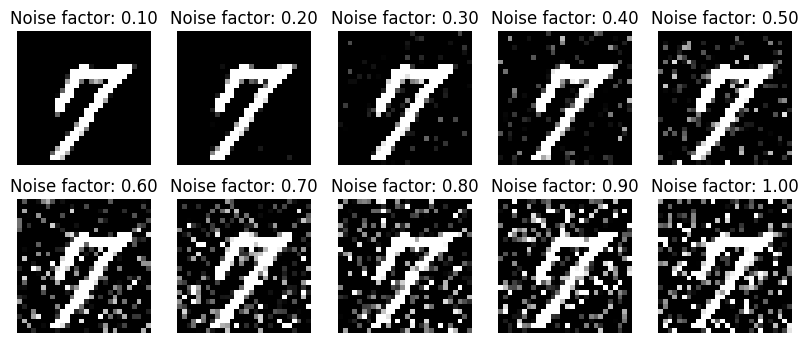

In [11]:
img, _ = next(iter(train_loader))

plt.figure(figsize=(10, 4))
for i, noise_factor in enumerate(np.linspace(0.1, 1, 10)):
    plt.subplot(2, 5, 1+i)
    plt.imshow(add_noise(img[0], noise_factor=noise_factor, devide='cpu').squeeze(), cmap='gray')
    plt.title(f'Noise factor: {noise_factor:.2f}')
    plt.axis('off')
plt.tight_layout
plt.show()

In [17]:
class Denoising_Autoencoder(nn.Module):
    def __init__(self):
        super(Denoising_Autoencoder, self).__init__()

        #Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        #Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
            )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

dummy_input = torch.randn(1, 1, 28, 28)
dummy_model = Denoising_Autoencoder()


In [18]:
def calc_shape_up_conv(in_shape, kernel_size, stride, padding, output_padding):
    return (in_shape - 1) * stride - 2 * padding + kernel_size + output_padding

def calc_shape_down_conv(in_shape, kernel_size, stride, padding):
    return (in_shape + 2 * padding - kernel_size) // stride + 1


calc_shape_up_conv(14, 3, 2, 1, 1)
calc_shape_down_conv(28, 3, 2, 1)

14

In [19]:
model = Denoising_Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
EPOCHS = 15